In [1]:
import numpy as np
import pandas as pd
import json
import os
from matplotlib import pyplot as plt
from astropy.modeling import models, fitting

import jungfrau_utils as ju
from alvra_tools import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


### Input which data to take...

In [2]:
#scan_name ="knife_edge_X_003"
#scan_name = "YAG_timing_FEL0.5_8uJ_008"
scan_name = "YAG_timing_FEL0.3_4uJ_008"

DIR = "/sf/alvra/data/p17984/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17984/res/scan_info/"

### Load the data using load PSSS function

In [3]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
numFiles = 1

print ("Processing",numFiles,"files")

Energy = []
FWHM = []
PulseID = []
X = []
Y = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    exists = os.path.isfile(filename)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        
        (Energy_shot, FWHM_shot, X_shot, Y_shot, pulseIDs) = \
        load_PSSS_data_from_scans_pulseID(filename,channel_PSSS_center, 50)

        
        Energy.append(Energy_shot)
        FWHM.append(FWHM_shot)
        X.append(X_shot)
        Y.append(Y_shot)
        PulseID.append(pulseIDs)
        
Energy = np.asarray(Energy)
FWHM = np.asarray(FWHM)
PulseID = np.asarray(PulseID)
X = np.asarray(X)
Y = np.asarray(Y)
print ("Job done!")

/sf/alvra/data/p17984/res/scan_info/YAG_timing_FEL0.3_4uJ_008_scan_info.json
Processing 1 files
step 1 of 1 : Processing /sf/alvra/data/p17984/raw/scan_data/YAG_timing_FEL0.3_4uJ_008/YAG_timing_FEL0.3_4uJ_008_step0000.BSREAD.h5
Job done!


### Re-shape the arrays

In [4]:
Energy = np.reshape(Energy, (-1,1))
PulseID = np.reshape(PulseID, (-1,1))
X=np.reshape(X,(-1,X.shape[2]))
Y=np.reshape(Y,(-1,Y.shape[2]))
FWHM = np.reshape(FWHM, (-1,1))

In [5]:
# merge Energy values with PulseID's
Energy_with_PulseID = np.append(Energy,PulseID,axis=1)
Energy_with_PulseID.shape

(500, 2)

### Remove rows with Zeros from the arrays with data

In [6]:
rows_to_del = np.nonzero(Energy==0)[0]

Energy = np.delete(Energy,rows_to_del,axis=0)
PulseID = np.delete(PulseID,rows_to_del,axis=0)
X = np.delete(X,rows_to_del,axis=0)
Y = np.delete(Y,rows_to_del, axis=0)
Energy_with_PulseID = np.delete(Energy_with_PulseID,rows_to_del,axis=0)
Y.shape

(500, 2560)

### Plot a single spectra

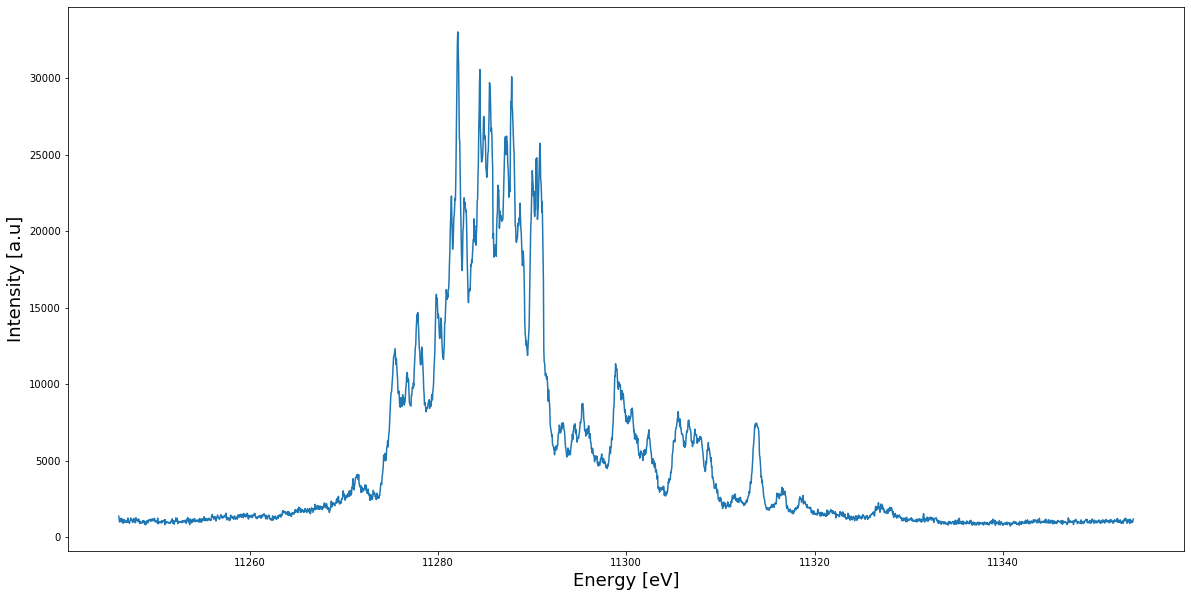

In [7]:
plt.figure(figsize=(20,10))
plt.plot(X[0], Y[5])
plt.xlabel('Energy [eV]', fontsize=18)
plt.ylabel('Intensity [a.u]', fontsize=18)
plt.show()

### Smooth spectra

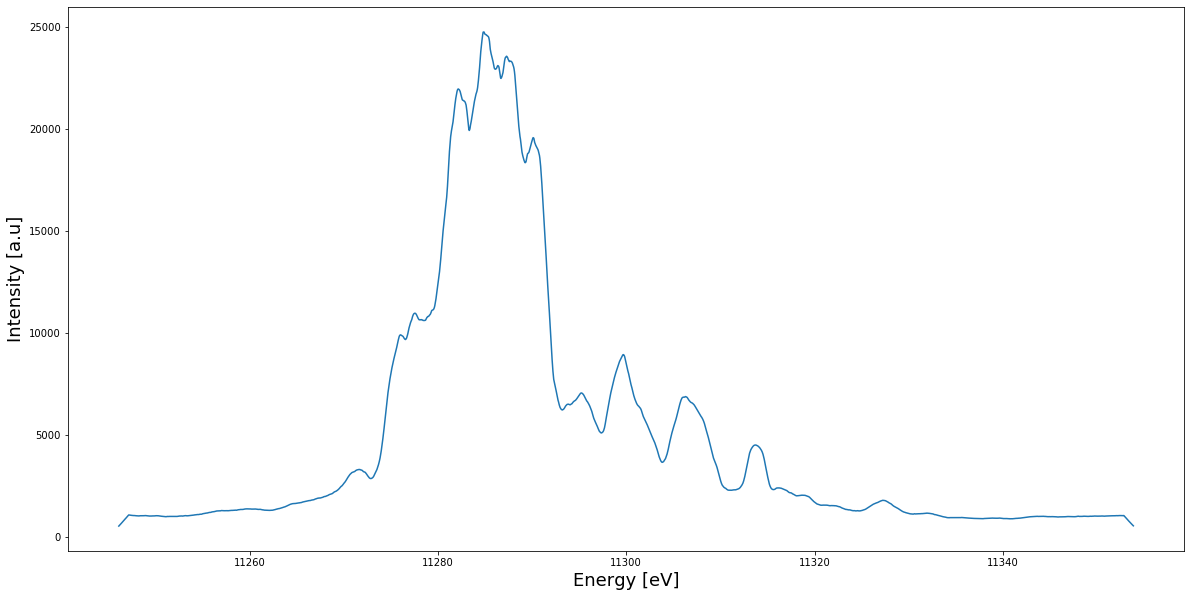

In [8]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(20,10))
plt.plot(X[0], smooth(Y[5],50))
plt.xlabel('Energy [eV]', fontsize=18)
plt.ylabel('Intensity [a.u]', fontsize=18)
plt.show()

### Fit the average spectra with astopy

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean              stddev     
    ----------------- ------------------ -----------------
    24116.04188244019 11292.923047136741 6.941641803810546
[11296.82275417]
[9982745862]


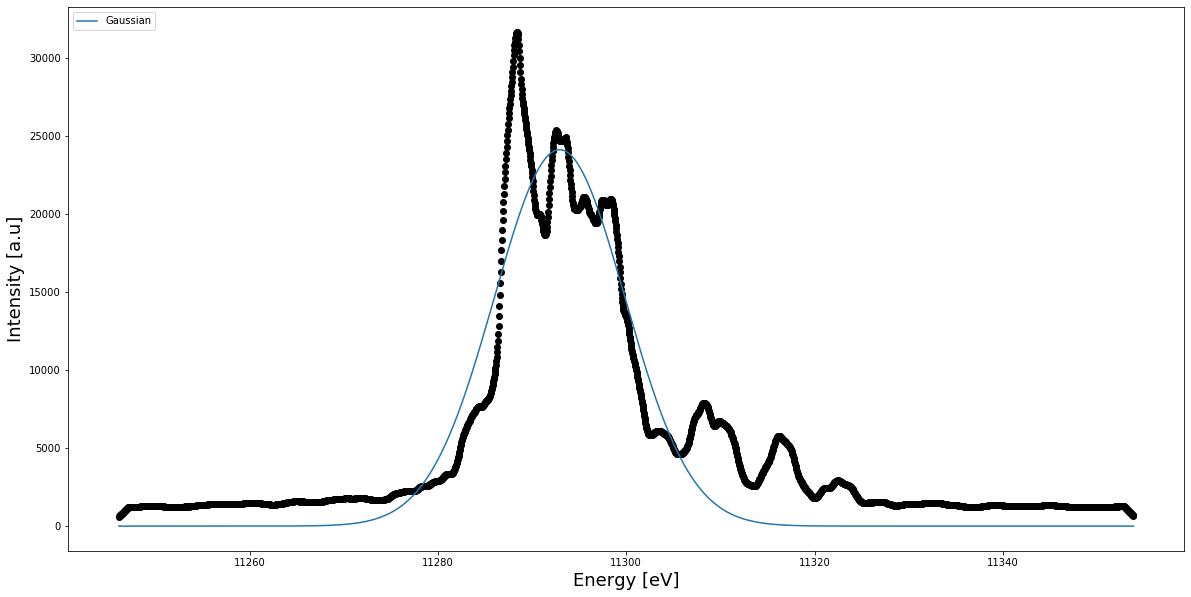

In [9]:
x = X[0]
y = smooth(Y[0],50)

#g_init = models.Gaussian1D(amplitude=10000., mean=11210, stddev=15.)
g_init = models.Gaussian1D(amplitude=40000., mean=11210, stddev=19.)

fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(20,10))
plt.plot(x, y, 'ko')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Energy [eV]', fontsize=18)
plt.ylabel('Intensity [a.u]', fontsize=18)
plt.legend(loc=2)
print(g)
print(Energy[8])
print(PulseID[8])

In [10]:
g.mean.value

11292.923047136741

### Fit all single spectra and compare to PSSS fit values

In [11]:
g_init = models.Gaussian1D(amplitude=40000., mean=11210, stddev=19.)
fit_g = fitting.LevMarLSQFitter()
Energy_fit_mean = []
Energy_fit_amp = []
Energy_fit_std = []
print(len(Y))

for i in range(0,len(Y)):
    y = smooth(Y[i],50)
    g = fit_g(g_init, x, y)
    #print(g.mean.value, " ", Energy[i])
    
    Energy_fit_mean.append(g.mean.value)
    Energy_fit_amp.append(g.amplitude.value)
    Energy_fit_std.append(g.stddev.value)
    

500


### Reshape arrays

In [12]:
Energy_fit_mean = np.reshape(Energy_fit_mean, (-1,1))
Energy_fit_amp = np.reshape(Energy_fit_amp, (-1,1))
Energy_fit_std = np.reshape(Energy_fit_std, (-1,1))
Energy_fit_mean.shape

(500, 1)

In [13]:
# merge Energy and Energy_fit values with PulseID's
Energy_PSSS_and_fit_with_PulseID = []
Energy_PSSS_and_fit_with_PulseID = np.append(Energy, Energy_fit_mean,axis=1)
Energy_PSSS_and_fit_with_PulseID = np.append(Energy_PSSS_and_fit_with_PulseID, PulseID, axis=1)

In [14]:
# calculate difference between PSSS and fit
diff = Energy_PSSS_and_fit_with_PulseID[:,0] - Energy_PSSS_and_fit_with_PulseID[:,1] 

### Plot differnece betweeen Energy PSSS and fit

Text(0, 0.5, 'Energy PSSS - fit [eV]')

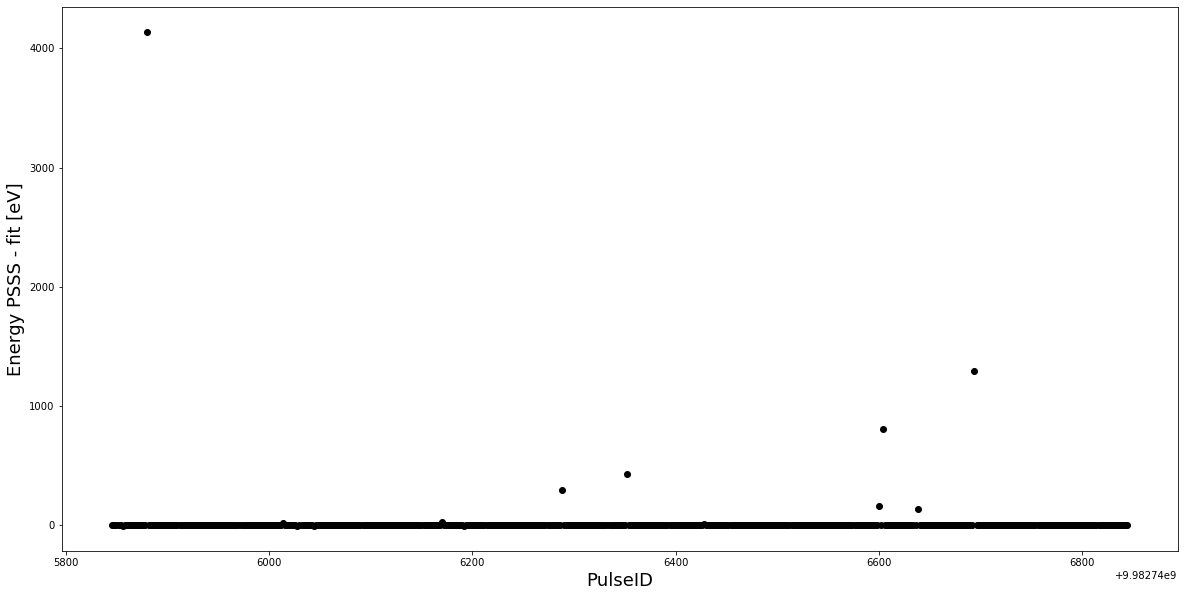

In [15]:
plt.figure(figsize=(20,10))
plt.plot(PulseID, diff, 'ko')
plt.xlabel('PulseID', fontsize=18)
plt.ylabel('Energy PSSS - fit [eV]', fontsize=18)
#plt.ylim(-2,1)
#plt.yscale('log')

In [16]:
#!ls $DIR

### save hdf5 file with the energy from PSS

In [17]:
h5_file = DIR + '/YAG_timing_FEL0.3_4uJ_008_step0049.JF06T08V01.h5'
h5_file

'/sf/alvra/data/p17984/raw/scan_data/YAG_timing_FEL0.3_4uJ_008//YAG_timing_FEL0.3_4uJ_008_step0049.JF06T08V01.h5'

In [18]:
update_channels("/das/work/p17/p17984/alvra_tools/alvra_tools/channels.ini")


ConfigFile(channel_BAM=S10BC01-DBAM070:EOM1_T1/data, channel_BS_pulse_ids=SLAAR11-LMOT-M451:ENC_1_BS/pulse_id, channel_Events=SAR-CVME-TIFALL5:EvtSet/data, channel_Izero=SAROP11-CVME-PBPS1:Lnk9Ch4-DATA-SUM/data, channel_Izero2=SAROP11-CVME-PBPS1:Lnk9Ch7-DATA-SUM/data, channel_Izero3=SAROP11-CVME-PBPS1:Lnk9Ch6-DATA-SUM/data, channel_Izero4=SAROP11-CVME-PBPS1:Lnk9Ch5-DATA-SUM/data, channel_JF_images=/data, channel_JF_pulse_ids=/pulse_id, channel_LaserDiode=SLAAR11-LSCP1-FNS:CH0:VAL_GET/data, channel_Laser_diag=SLAAR11-LSCP1-FNS:CH4:VAL_GET/data, channel_Laser_refDiode=SLAAR11-LSCP1-FNS:CH2:VAL_GET/data, channel_PALM=SLAAR11-LTIM01-EVR0:DUMMY_PV5_NBS/data, channel_PALM_drift=SAROP11-PALMK118:CH2_VAL_GET/data, channel_PALM_eTOF=SAROP11-PALMK118:CH2_BUFFER/data, channel_PIPS_fluo=SARES11-GES1:CH2_VAL_GET/data, channel_PIPS_trans=SARES11-GES1:CH1_VAL_GET/data, channel_PSSS_center=SARFE10-PSSS059:SPECTRUM_CENTER/data, channel_PSSS_fwhm=SARFE10-PSSS059:SPECTRUM_FWHM/data, channel_PSSS_x=SARFE1

### try with gerneric hdf5 file handling

In [19]:
jf_file = h5py.File(h5_file)
print(jf_file)
#channel_raw_JF_images = "/data/JF06T08V01/data"

images = jf_file[channel_raw_JF_images]

nframes=images.shape[0]

for i in range(nframes):
    image = images[i][:]
    
print(image)

<HDF5 file "YAG_timing_FEL0.3_4uJ_008_step0049.JF06T08V01.h5" (mode r)>
[[2797 2500 2378 ... 2184 2252 2451]
 [2516 2566 2523 ... 2335 2211 2219]
 [2550 2361 2543 ... 2563 2156 2447]
 ...
 [2856 2555 2698 ... 2904 2873 2888]
 [2711 2611 2798 ... 2982 2731 2751]
 [2852 2865 2479 ... 2784 3059 2723]]


### use alvra_tools for reading and writting

In [32]:
# file to load
h5_file = DIR + '/YAG_timing_FEL0.3_4uJ_008_step0049.JF06T08V01.h5'
h5_file

#load data
data = load_JF_data(h5_file)

### save the h5 file

In [31]:
path = '/das/work/p17/p17984/karol/PSSS/test.h5'
save(path, data=data[:][0], pulse_id=data[:][1], energy_psss=Energy, energy_fit=Energy_fit_mean)

In [22]:
Energy

array([[11292.71675976],
       [11294.37873128],
       [11298.81665408],
       [11300.80138831],
       [11295.61764534],
       [11285.47321517],
       [11295.19560493],
       [11291.20659415],
       [11296.82275417],
       [11294.15098136],
       [11300.25815131],
       [11296.81500998],
       [11298.51861541],
       [11301.66915696],
       [11292.94940827],
       [11306.82513345],
       [11303.03937382],
       [11334.17801428],
       [11301.75358948],
       [11301.96669011],
       [11298.22852368],
       [11306.22073231],
       [11305.24780097],
       [11299.52779348],
       [11305.45521623],
       [11308.50058942],
       [11302.76488047],
       [11302.06359646],
       [11300.53559205],
       [11302.31004784],
       [11305.39426311],
       [11303.39246343],
       [11288.66194251],
       [11299.86908479],
       [11299.61320474],
       [11299.05591404],
       [11292.22395861],
       [11292.94539407],
       [11294.03743252],
       [11288.47428645],


In [27]:
jf_file = h5py.File(path)
print(jf_file)
#channel_raw_JF_images = "/data/JF06T08V01/data"

en = jf_file['energy']
print(en[0])

<HDF5 file "test.h5" (mode r+)>
[11292.71675976]
